In [ ]:
!pip install gym

In [ ]:
!pyyaml

/bin/bash: pyyaml: command not found


In [ ]:
import torch
from torch import nn
import gym
import random
from collections import deque
import os
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [ ]:
def modelQnn(env_shape, action_shape):

    return nn.Sequential(
        nn.Embedding(env_shape, 300),
        nn.Linear(300,300),
        nn.ReLU(),
        nn.Linear(300, 256),
        nn.ReLU(),
        nn.Linear(256,64),
        nn.ReLU(),
        nn.Linear(64, action_shape)
    )

In [ ]:
class DQN:
    def __init__(self, env, conf):
        self.env = env
        self.state_size = self.env.observation_space.n
        self.action_size = self.env.action_space.n
        self.num_episodes = conf["num_episodes"]
        self.memory = deque(maxlen=3000)

        self.gamma = conf["gamma"]
        self.epsilon = conf["epsilon"]
        self.epsilon_min = conf['epsilon_min']
        self.epsilon_decay = conf["epsilon_decay"]
        self.batch_size = conf["batch_size"]
        self.train_start = conf["train_start"]
        self.lr = conf["lr"]
        self.model = modelQnn(self.state_size, self.action_size)
        self.target_model = modelQnn(self.state_size, self.action_size)
        self.episode_durations = []
        self.reward_in_episode = []
        self.epsilon_vec = []
        self.loss = None
        self.last_step = 0
        self.last_episode = 0

    def select_action(self, state):
        if random.random() > self.epsilon:
            return self.model(torch.tensor([state])).max(1)[1].item()
        else:
            return self.env.action_space.sample()

    def memories(self,state, action, reward, next_state, done):
        """
        Store past experience need for taining
        """
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def one_hot(self, state):
        one_hot = torch.zeros(self.state_size)
        one_hot[state] = 1
        return one_hot

    def replay(self):
        """
        Select from memories and then train the model
        """

        if len(self.memory) < self.train_start:
            return

        minibatch =  random.sample(self.memory, min(len(self.memory), self.batch_size))
        
        state = torch.zeros((self.batch_size, self.state_size))
        next_state = torch.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])
        
        action = torch.tensor(action)
        reward = torch.tensor(reward)
        done = torch.tensor(done)
        predicted_q_value = self.model(state.long()).max(1)[0]
        next_state_values= self.target_model(next_state.long()).max(1)[0]
        expected_q_value = (done[...,None] *next_state_values * self.gamma) + reward[...,None]
        
        loss = self.loss(predicted_q_value, expected_q_value)

        self.optim.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optim.step()

    def run(self):
      self.optim = optim.Adam(self.model.parameters(), lr=self.lr)
      self.loss = F.mse_loss
      self.episode_durations = []
      self.reward_in_episode = []
      self.epsilon_vec = []
      reward_in_episode = 0
      
      for e in range(self.num_episodes):
        reward_episode = 0
        state = self.env.reset()
        done = False
        i = 0
        while not done:
          action = self.select_action(state)
          next_state, reward, done, _ = env.step(action)
          self.memories(state, action, reward, next_state, done)
          if not done or i == self.env._max_episode_steps-1:
            self.replay()

          state = next_state
          reward_in_episode +=reward
          i +=1
          if done:
            self.episode_durations.append(i)
            self.reward_in_episode.append(reward_in_episode)
            self.epsilon_vec.append(self.epsilon)
            reward_in_episode = 0
            N = min(10, len(self.episode_durations))
            print(f"reward {np.mean(self.reward_in_episode[-N:])}, \
                  steps: {np.mean(self.episode_durations[-N:])}, \
                  epsilon: {self.epsilon}")
          
          
          # self.replay()

    

In [ ]:
conf ={
    "num_episodes": 1000,
    "gamma" : 0.95,
    "epsilon" : 1.0,
    "epsilon_min" : 0.001,
    "epsilon_decay" : 0.999,
    "batch_size" : 64,
    "train_start" : 1000,
    "lr": 0.01
}

env = gym.make('Taxi-v3')
agent = DQN(env, conf)

In [112]:
agent.run()

reward -641.0,                   steps: 200.0,                   epsilon: 1.0
reward -713.0,                   steps: 200.0,                   epsilon: 1.0
reward -713.0,                   steps: 200.0,                   epsilon: 1.0
reward -715.25,                   steps: 200.0,                   epsilon: 1.0
reward -722.0,                   steps: 200.0,                   epsilon: 1.0
reward -738.5,                   steps: 200.0,                   epsilon: 0.818648829478636
reward -737.4285714285714,                   steps: 200.0,                   epsilon: 0.6701859060067403
reward -742.25,                   steps: 200.0,                   epsilon: 0.5486469074854965
reward -721.0,                   steps: 200.0,                   epsilon: 0.4491491486100748
reward -717.5,                   steps: 200.0,                   epsilon: 0.3676954247709635
reward -707.6,                   steps: 200.0,                   epsilon: 0.3010134290933992
reward -691.4,                   steps:

KeyboardInterrupt: ignored

In [113]:
import matplotlib.pyplot as plt

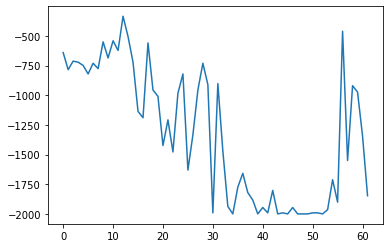

In [118]:
plt.plot(agent.reward_in_episode)